<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M0.532 · Pattern Recognition</p>
<p style="margin: 0; text-align:right;">Computational Engineering and Mathematics Master</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Computers, Multimedia and Telecommunications Department</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

Whereas the previous notebooks on object detection based on Faster R-CNN and Mask R-CNN are considered two-stage object detectors, in this notebook we will use the YOLOv3 object detector, a one-stage object detector, which is faster than those models belonging to the family of two-stage object detectors.

First, we will see how to use a pre-trained YOLOv3 model for inference. Later, we will see how to train this model on a custom dataset.

The YOLOv3 code in Pytorhc used in this notebook is based on [this repository code](https://github.com/eriklindernoren/PyTorch-YOLOv3).

## YOLOv3 inference

First of all, we need to install pytorchyolo library.

In [ ]:
!pip install pytorchyolo

     |████████████████████████████████| 42 kB 511 kB/s 
     |████████████████████████████████| 948 kB 8.2 MB/s 
     |████████████████████████████████| 3.1 MB 37.6 MB/s 
     |████████████████████████████████| 11.2 MB 47.0 MB/s 
     |████████████████████████████████| 884 kB 31.6 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 1.7.0
    Uninstalling importlib-metadata-1.7.0:
      Successfully uninstalled importlib-metadata-1.7.0
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does no

Then, we need to download the weights from the pretrained model.

In [ ]:
!wget -c "https://pjreddie.com/media/files/yolov3.weights" --header "Referer: pjreddie.com"

--2021-12-07 20:52:08--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  61.6MB/s    in 4.1s    

2021-12-07 20:52:13 (58.0 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



We also need to download the configuration file of the pretrained model. It is in this file that the architecture of the model is defined.

In [ ]:
!wget "https://raw.githubusercontent.com/eriklindernoren/PyTorch-YOLOv3/master/config/yolov3.cfg"

--2021-12-07 20:52:15--  https://raw.githubusercontent.com/eriklindernoren/PyTorch-YOLOv3/master/config/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8339 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.14K  --.-KB/s    in 0s      

2021-12-07 20:52:15 (68.7 MB/s) - ‘yolov3.cfg’ saved [8339/8339]



We mount the Google Drive on the Google Colab in order to use some images to test the pretrained YOLOv3 model.

In [ ]:
from google.colab import drive
 
drive.mount('/content/drive')

We also define the different category names included in COCO, which are the ones that have been used for training the model.

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

We define an object_detection_api that shows the predicted bounding boxes and the corresponding category names on top of the image used for inference.

In [ ]:
import matplotlib.pyplot as plt

def object_detection_api(img, boxes, rect_th=3, text_size=3, text_th=3):

    for i in range(len(boxes)):
        # Draw Rectangle with the coordinates
        cv2.rectangle(img, (boxes[i][0],boxes[i][1]), (boxes[i][2],boxes[i][3]),color=(0, 255, 0), thickness=rect_th) 
        # Write the prediction class
        pred_class = COCO_INSTANCE_CATEGORY_NAMES[int(boxes[i][5])]
        cv2.putText(img,pred_class, (boxes[i][0],boxes[i][1]),  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) 
    plt.figure(figsize=(20,30)) # display the output image
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

Finally, once we have all the helper functions implemented and the configuration files defined, we can use the model to get the predictions on any image. We first load the model specifying the configuration and weights filenames of the pretrained model. Then, we read the image that we want to use for inference. Finally, we apply the detect_image function from the detect module included in pytorchyolo and we visualize the predicted bounding boxes with the object_detection_api.

In [ ]:
import cv2
from pytorchyolo import detect, models

# Load the YOLO model
model = models.load_model("./yolov3.cfg", "./yolov3.weights")

# Load the image as a numpy array
img = cv2.imread('/content/drive/My Drive/Docència/Reconeixement de Patrons/Notebooks/Object Detection/Images/traffic.jpg')

# Convert OpenCV bgr to rgb
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Runs the YOLO model on the image 
boxes = detect.detect_image(model, img)

print(boxes)
# Output will be a numpy array in the following format:
# [[x1, y1, x2, y2, confidence, class]]

object_detection_api(img, boxes, rect_th=2, text_th=1, text_size=1)

## YOLOv3 training

Now, instead of just using YOLOv3 for inference, we want to train this object detector on a custom dataset. Let's first clone the github repo. It is a fork of the original one since the requirements of poetry.lock and pyproject.toml required some changes related with the Python version.

In [ ]:
!git clone https://github.com/carlesventura/PyTorch-YOLOv3

Cloning into 'PyTorch-YOLOv3'...
remote: Enumerating objects: 1767, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 1767 (delta 44), reused 31 (delta 11), pack-reused 1679
Receiving objects: 100% (1767/1767), 16.49 MiB | 31.68 MiB/s, done.
Resolving deltas: 100% (1059/1059), done.


We install poetry, which is a tool to make easier the Python packaging and the dependency management.

In [ ]:
!pip install -q --pre poetry


     |████████████████████████████████| 190 kB 5.2 MB/s 
     |████████████████████████████████| 40 kB 5.0 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 7.2 MB 17.4 MB/s 
     |████████████████████████████████| 421 kB 46.1 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 58 kB 5.7 MB/s 
     |████████████████████████████████| 58 kB 5.2 MB/s 
     |████████████████████████████████| 3.6 MB 45.0 MB/s 
     |████████████████████████████████| 461 kB 46.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 1.7.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.

We change our current directory.

In [ ]:
%cd PyTorch-YOLOv3/

/content/PyTorch-YOLOv3


We add ipykernel, since this dependency was missing.

In [ ]:
!poetry add ipykernel

Creating virtualenv pytorchyolo-9v2T40J2-py3.7 in /root/.cache/pypoetry/virtualenvs
Using version ^6.6.0 for ipykernel

Updating dependencies
Resolving dependencies... (66.9s)

Writing lock file

Package operations: 69 installs, 2 updates, 0 removals

  • Installing certifi (2021.10.8): Pending...
  • Installing charset-normalizer (2.0.8): Pending...
  • Installing idna (3.3): Pending...
  • Installing pyasn1 (0.4.8): Pending...
  • Installing six (1.16.0): Pending...
  • Installing urllib3 (1.22): Pending...
  • Installing certifi (2021.10.8): Downloading... 0%
  • Installing charset-normalizer (2.0.8): Pending...
  • Installing idna (3.3): Pending...
  • Installing pyasn1 (0.4.8): Pending...
  • Installing six (1.16.0): Pending...
  • Installing urllib3 (1.22): Pending...
  • Installing charset-normalizer (2.0.8): Downloading... 0%
  • Installing idna (3.3): Pending...
  • Installing pyasn1 (0.4.8): Pending...
  • Installing six (1.16.0): Pending...
  • Installing urllib3 (1.22): Pen

We download the weights of the YOLOv3 pre-trained model on COCO since we don't want to train our model from scratch.

In [ ]:
!wget -c "https://pjreddie.com/media/files/yolov3.weights" --header "Referer: pjreddie.com"

--2021-12-10 10:04:30--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  61.3MB/s    in 4.1s    

2021-12-10 10:04:35 (57.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



We move the weights filename to the folder weights.

In [ ]:
!mv yolov3.weights weights/

Before training, we check that the pretrained model works well by running the yolo-detect script on some sample images included in the repo.

In [ ]:
!poetry run yolo-detect --images data/samples/

Environment information:
System: Linux 5.4.104+
Current Version: pytorchyolo 1.6.0
Current Commit Hash: f16b0c8
Command line arguments: Namespace(batch_size=1, classes='data/coco.names', conf_thres=0.5, images='data/samples/', img_size=416, model='config/yolov3.cfg', n_cpu=8, nms_thres=0.4, output='output', weights='weights/yolov3.weights')
/root/.cache/pypoetry/virtualenvs/pytorchyolo-9v2T40J2-py3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Detecting: 100% 9/9 [00:01<00:00,  7.00it/s]
Image data/samples/dog.jpg:
	+ Label: dog | Confidence: 0.9929
	+ Label: bicycle | Confidence: 0.9925
	+ L

We visualize the result on one of this sample images.

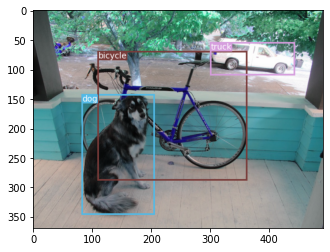

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('output/dog.png')
plt.imshow(img)



Now, let's move to train our own model. First thing we need is to run the script create_custom_model.sh.

In [ ]:
!sh ./config/create_custom_model.sh 3

Next, we need to generate a file named classes.name with the category names in each line of the file. Here, we will train a dataset of fruits with apples, bananas and oranges.

In [ ]:
with open('data/custom/classes.names', 'w') as f:
    f.write('apple\n')
    f.write('banana\n')
    f.write('orange\n')

We also mount our Google Drive account on Google Colab to have access to the dataset that we want to use.

In [ ]:
from google.colab import drive
 
drive.mount('/content/drive')

Mounted at /content/drive


We are required to put the training and testing images to the folder data/custom/images/ of our repo. The training images filenames are changed to train_1.jpg, train_2.jpg...

In [ ]:
import os
from shutil import copyfile

# defining the files directory and testing directory
train_dir = '/content/drive/My Drive/Docència/Reconeixement de Patrons/Notebooks/Object Detection/Images/FruitsDataset/train_zip/train/'
test_dir = '/content/drive/My Drive/Docència/Reconeixement de Patrons/Notebooks/Object Detection/Images/FruitsDataset/test_zip/test/'

imgs_train = [image for image in sorted(os.listdir(train_dir)) if image[-4:]=='.jpg']

idx = 1
for image in imgs_train:
  src_name = train_dir+image
  #print(src_name)
  dst_name = 'data/custom/images/train_' + str(idx) + '.jpg'
  copyfile(src_name,dst_name)
  idx = idx + 1


#print(imgs)

We do the same for the testing images.

In [ ]:
# defining the files directory and testing directory
train_dir = '/content/drive/My Drive/Docència/Reconeixement de Patrons/Notebooks/Object Detection/Images/FruitsDataset/train_zip/train/'
test_dir = '/content/drive/My Drive/Docència/Reconeixement de Patrons/Notebooks/Object Detection/Images/FruitsDataset/test_zip/test/'

imgs_test = [image for image in sorted(os.listdir(test_dir)) if image[-4:]=='.jpg']

idx = 1
for image in imgs_test:
  src_name = test_dir+image
  #print(src_name)
  dst_name = 'data/custom/images/test_' + str(idx) + '.jpg'
  copyfile(src_name,dst_name)
  idx = idx + 1

We also need to move the annotation files to the data/custom/labels/ folder. The original bounding box annotations are given in absolute value locations but the annotations for YOLOv3 needs to be normalized according to the image size with values between 0 and 1. Furthermore, instead of xmin, xmax, ymin and ymax values, YOLOv3 requires to have x_center, y_center, width and height. We generate a txt file for each image where each line correspond to one of the objects in the images by specifying first the category label and then the 4 components of the bounding box.

In [ ]:
# xml library for parsing xml files
from xml.etree import ElementTree as et

import cv2

classes = ['apple','banana','orange']

idx = 1
for img_name in imgs_train:

  image_path = os.path.join(train_dir, img_name)
  img = cv2.imread(image_path)

  # cv2 image gives size as height x width
  wt = img.shape[1]
  ht = img.shape[0]

  # annotation file
  annot_filename = img_name[:-4] + '.xml'
  annot_file_path = os.path.join(train_dir, annot_filename)

  boxes = []
  labels = []
  tree = et.parse(annot_file_path)
  root = tree.getroot()

  # box coordinates for xml files are extracted and corrected for image size given
  for member in root.findall('object'):
      labels.append(classes.index(member.find('name').text))
      
      # bounding box
      xmin = int(member.find('bndbox').find('xmin').text)
      xmax = int(member.find('bndbox').find('xmax').text)
      
      ymin = int(member.find('bndbox').find('ymin').text)
      ymax = int(member.find('bndbox').find('ymax').text)
      
      
      xmin_norm = xmin/wt
      xmax_norm = xmax/wt
      ymin_norm = ymin/ht
      ymax_norm = ymax/ht

      width = xmax_norm-xmin_norm
      height = ymax_norm-ymin_norm
      x_center = xmin_norm + width/2
      y_center = ymin_norm + height/2
      
      boxes.append([x_center, y_center, width, height])

  annot_filename_new = 'train_' + str(idx) + '.txt'
  annot_file_path_new = os.path.join('data/custom/labels/', annot_filename_new)

  with open(annot_file_path_new, 'w') as f:
    for i in range(len(labels)):
      f.write(str(labels[i]) + " " + str(boxes[i][0]) + " " + str(boxes[i][1]) + " " + str(boxes[i][2]) + " " + str(boxes[i][3]) + "\n")

  idx = idx + 1

We make a manual stratified split. This way, the representation of each category in the test set is the same as in the training set.

In [ ]:
num_elems = [75, 73, 20, 72] #apple, banana, mixed, orange

train_split = 'data/custom/train.txt'
val_split = 'data/custom/valid.txt'

idxs_train = []
idxs_val = []

start_range = 0

for num_elems_cat in num_elems:
  train_elems = int(0.7*num_elems_cat)
  for i in range(train_elems):
    idxs_train.append(start_range + i)
  val_elems = num_elems_cat - train_elems
  for i in range(val_elems):
    idxs_val.append(start_range + train_elems + i)
  start_range = start_range + num_elems_cat
  

with open(train_split, 'w') as f:
  for idx in idxs_train:
    f.write('data/custom/images/train_' + str(idx+1) + '.jpg\n')

with open(val_split, 'w') as f:
  for idx in idxs_val:
    f.write('data/custom/images/train_' + str(idx+1) + '.jpg\n')




We move the generated yolov3-custom.cfg configuration file to the config folder.

In [ ]:
!mv yolov3-custom.cfg config/

Once we have all the data annotated with the expected format, we are ready for training our model. For that we need to run the yolo-train script specifying the model and the data we want to use. We will train the model for 30 epochs and saving the model trained every 5 epochs.

In [ ]:
!poetry run yolo-train --model config/yolov3-custom.cfg --data config/custom.data --epochs 30 --checkpoint_interval 5

Environment information:
System: Linux 5.4.104+
Current Version: pytorchyolo 1.6.0
Current Commit Hash: f16b0c8
Command line arguments: Namespace(checkpoint_interval=5, conf_thres=0.1, data='config/custom.data', epochs=30, evaluation_interval=1, iou_thres=0.5, logdir='logs', model='config/yolov3-custom.cfg', multiscale_training=False, n_cpu=8, nms_thres=0.5, pretrained_weights=None, seed=-1, verbose=False)
/root/.cache/pypoetry/virtualenvs/pytorchyolo-9v2T40J2-py3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

---- Training Model ----
Training Epoch 1:   0% 0/11 [00:00<?, ?it/s]/root/.cache/p

Once we have our model trained, we can use it for inference by running the yolo-detect script, as we already did in the first part of this notebook.

In [ ]:
!poetry run yolo-detect --images data/custom/images/ --output output_fruits --model config/yolov3-custom.cfg --weights checkpoints/yolov3_ckpt_30.pth --classes data/custom/classes.names

Environment information:
System: Linux 5.4.104+
Current Version: pytorchyolo 1.6.0
Current Commit Hash: f16b0c8
Command line arguments: Namespace(batch_size=1, classes='data/custom/classes.names', conf_thres=0.5, images='data/custom/images/', img_size=416, model='config/yolov3-custom.cfg', n_cpu=8, nms_thres=0.4, output='output_fruits', weights='checkpoints/yolov3_ckpt_30.pth')
/root/.cache/pypoetry/virtualenvs/pytorchyolo-9v2T40J2-py3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Detecting:  69% 208/301 [00:15<00:06, 14.59it/s]/root/.cache/pypoetry/virtualenvs/pytorchyolo-9v2T40J2-py3.7/lib/

It seems that the model trained is not working approppriately since almost no objects are being detected. Here we have an example where a banana was detected in one of the training images.

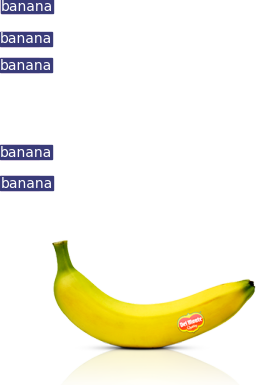

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread('output_fruits/train_90.png')
cv2_imshow(img)

We also check how works the pretrained model on this dataset.

In [ ]:
!poetry run yolo-detect --images data/custom/images/ --output output_fruits_pretrained

Environment information:
System: Linux 5.4.104+
Current Version: pytorchyolo 1.6.0
Current Commit Hash: f16b0c8
Command line arguments: Namespace(batch_size=1, classes='data/coco.names', conf_thres=0.5, images='data/custom/images/', img_size=416, model='config/yolov3.cfg', n_cpu=8, nms_thres=0.4, output='output_fruits_pretrained', weights='weights/yolov3.weights')
/root/.cache/pypoetry/virtualenvs/pytorchyolo-9v2T40J2-py3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Detecting:  69% 209/301 [00:16<00:06, 13.59it/s]/root/.cache/pypoetry/virtualenvs/pytorchyolo-9v2T40J2-py3.7/lib/python3.7/site

We can see that the pretrained model works quite good. Not only the specific categories annotated on this dataset are predicted, but also other ones like diningtable.

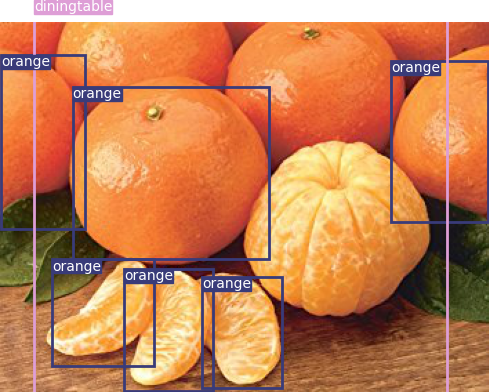

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread('output_fruits_pretrained/test_55.png')
cv2_imshow(img)

We try to train again our own model but using the pretrained model to initialize the weights of our model. This is done by using the argument --pretrained_weights.

In [ ]:
!poetry run yolo-train --model config/yolov3-custom.cfg --data config/custom.data --epochs 30 --checkpoint_interval 5 --pretrained_weights weights/yolov3.weights

Environment information:
System: Linux 5.4.104+
Current Version: pytorchyolo 1.6.0
Current Commit Hash: f16b0c8
Command line arguments: Namespace(checkpoint_interval=5, conf_thres=0.1, data='config/custom.data', epochs=30, evaluation_interval=1, iou_thres=0.5, logdir='logs', model='config/yolov3-custom.cfg', multiscale_training=False, n_cpu=8, nms_thres=0.5, pretrained_weights='weights/yolov3.weights', seed=-1, verbose=False)
/root/.cache/pypoetry/virtualenvs/pytorchyolo-9v2T40J2-py3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

---- Training Model ----
Training Epoch 1:   0% 0/11 [00:00<?, 

With the new trained model, we check again the predictions on the fruits dataset.

In [ ]:
!poetry run yolo-detect --images data/custom/images/ --output output_fruits_pretrained_finetuned --model config/yolov3-custom.cfg --weights checkpoints/yolov3_ckpt_30.pth --classes data/custom/classes.names

Environment information:
System: Linux 5.4.104+
Current Version: pytorchyolo 1.6.0
Current Commit Hash: f16b0c8
Command line arguments: Namespace(batch_size=1, classes='data/custom/classes.names', conf_thres=0.5, images='data/custom/images/', img_size=416, model='config/yolov3-custom.cfg', n_cpu=8, nms_thres=0.4, output='output_fruits_pretrained_finetuned', weights='checkpoints/yolov3_ckpt_30.pth')
/root/.cache/pypoetry/virtualenvs/pytorchyolo-9v2T40J2-py3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Detecting:  69% 208/301 [00:15<00:06, 14.30it/s]/root/.cache/pypoetry/virtualenvs/pytorchyol

It seems to be working much better than the model trained from scratch, but there are still many images where no objects were detected.

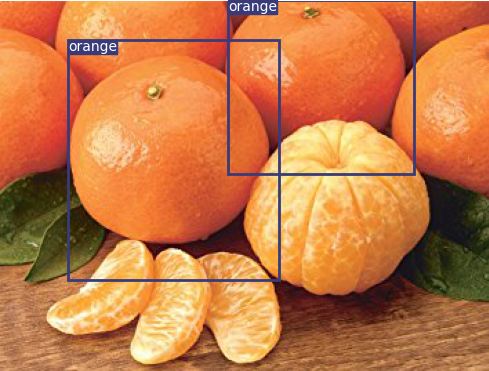

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread('output_fruits_pretrained_finetuned/test_55.png')
cv2_imshow(img)